In [21]:
# We are going to compare the results obtained doing PCA analysis of the europe.csv against the results obtained using Oja's algorithm.

from core.oja import Oja
from core.sanger import Sanger
from sklearn.decomposition import PCA
import pandas as pd
from utils.eta_function import divide_by_epoch

# Load the data
full_data = pd.read_csv("../data/europe.csv")

# Remove the 'Country' column
data = full_data.drop(columns=["Country"])

# Normalize the data
data = (data - data.mean()) / data.std()

num_components = 3
# Create the PCA object
pca = PCA(n_components=num_components)

# Fit the data
pca.fit(data)

# Create the Oja object
oja = Oja(seed=42, num_features=data.shape[1], eta_function=divide_by_epoch)

# Fit the data
oja_weights = oja.fit(data.values, epochs=10000)

# Create Sanger object
sanger = Sanger(seed=42, num_features=data.shape[1], num_components=num_components, eta_function=divide_by_epoch)

# Fit the data
sanger_weights = sanger.fit(data.values, epochs=10000)



Oja rule completed 10000 epochs.
Converged after 211 epochs.
Sanger's rule completed 211 epochs.


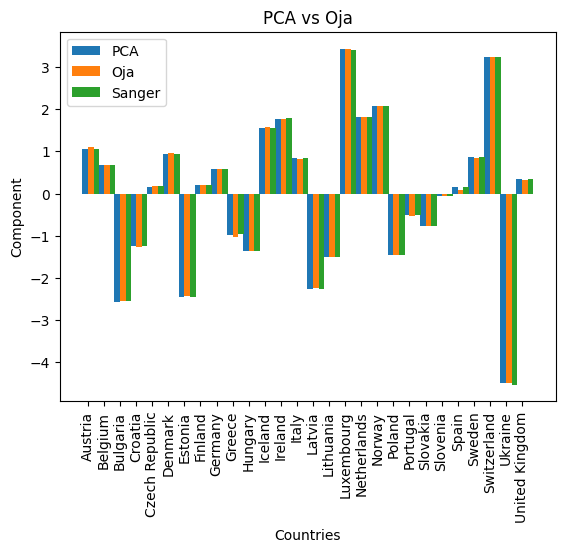

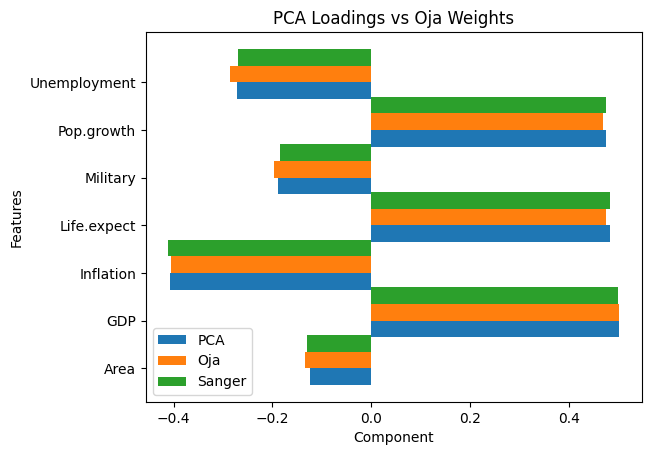

In [22]:
import numpy as np
import matplotlib.pyplot as plt


# Plot the results of PCA vs Oja in a vertical bar plot
# We are going to plot the first component of PCA and Oja
# We are using one vertical bar per country
# Each bar will have two colors, one for PCA and one for Oja

# Get the first component of PCA
components_pca = pca.transform(data)
pca_component = components_pca[:, 0]

# gotta get the first component of Oja. I have the weights, but I need to multiply them by the data
oja_component = np.dot(data.values, oja_weights)

# get first component of Sanger
sanger_component = np.dot(data.values, sanger_weights[0])

# make the oja and pca components have the same sign
if np.corrcoef(pca_component, oja_component)[0, 1] < 0:
    oja_component = -oja_component

# make the sanger and pca components have the same sign
if np.corrcoef(pca_component, sanger_component)[0, 1] < 0:
    sanger_component = -sanger_component

# Get the countries
countries = full_data["Country"]

# Create the figure
fig, ax = plt.subplots()

# Create the index
index = np.arange(len(countries))

# Create the width of the bars
bar_width = 0.35

# Create the bars
pca_bars = ax.bar(index, pca_component, bar_width, label="PCA")
oja_bars = ax.bar(index + bar_width, oja_component, bar_width, label="Oja")
sanger_bars = ax.bar(index + 2*bar_width, sanger_component, bar_width, label="Sanger")

# Set the labels
ax.set_xlabel('Countries')
ax.set_ylabel('Component')
ax.set_title('PCA vs Oja')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(countries, rotation=90)
ax.legend()

# Show the plot
plt.show()


# Plot the results of PCA loadings vs Oja weights
# We are using a horizontal bar plot to compare the loadings of PCA and the weights of Oja

# Get the loadings of PCA
loadings_pca = pca.components_[0]

# Create the index
index = np.arange(len(loadings_pca))

# Create the figure
fig, ax = plt.subplots()

# make the oja weights have the same sign as the pca loadings
if np.corrcoef(loadings_pca, oja_weights)[0, 1] < 0:
    oja_weights = -oja_weights

# make the sanger weights have the same sign as the pca loadings
if np.corrcoef(loadings_pca, sanger_weights[0])[0, 1] < 0:
    sanger_weights = -sanger_weights

# Create the bars
pca_bars = ax.barh(index, loadings_pca, bar_width, label="PCA")
oja_bars = ax.barh(index + bar_width, oja_weights, bar_width, label="Oja")
sanger_bars = ax.barh(index + 2*bar_width, sanger_weights[0], bar_width, label="Sanger")

# Set the labels
ax.set_xlabel('Component')
ax.set_ylabel('Features')
ax.set_title('PCA Loadings vs Oja Weights')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(full_data.columns[1:], rotation=0)
ax.legend()

# Show the plot
plt.show()



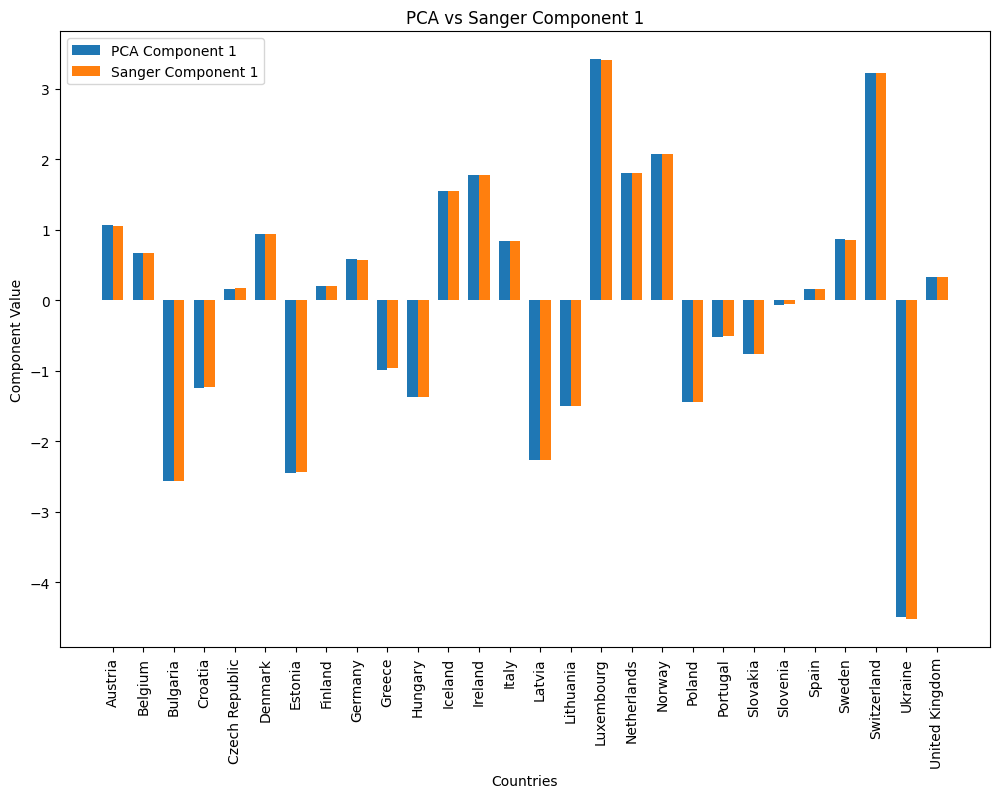

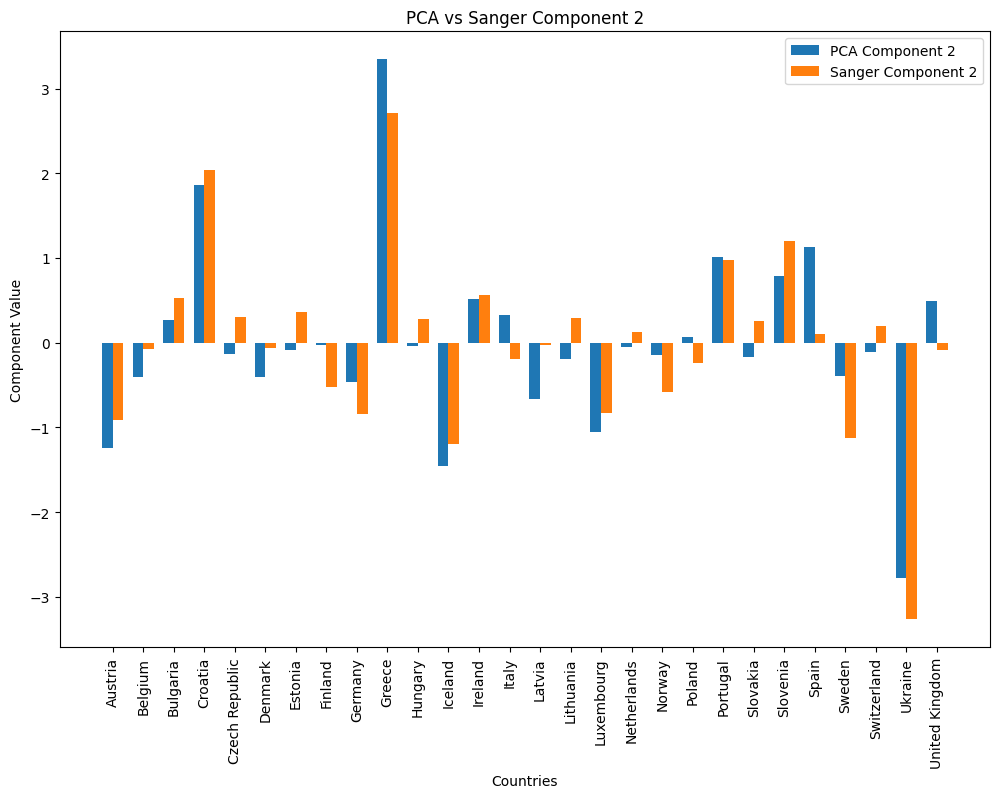

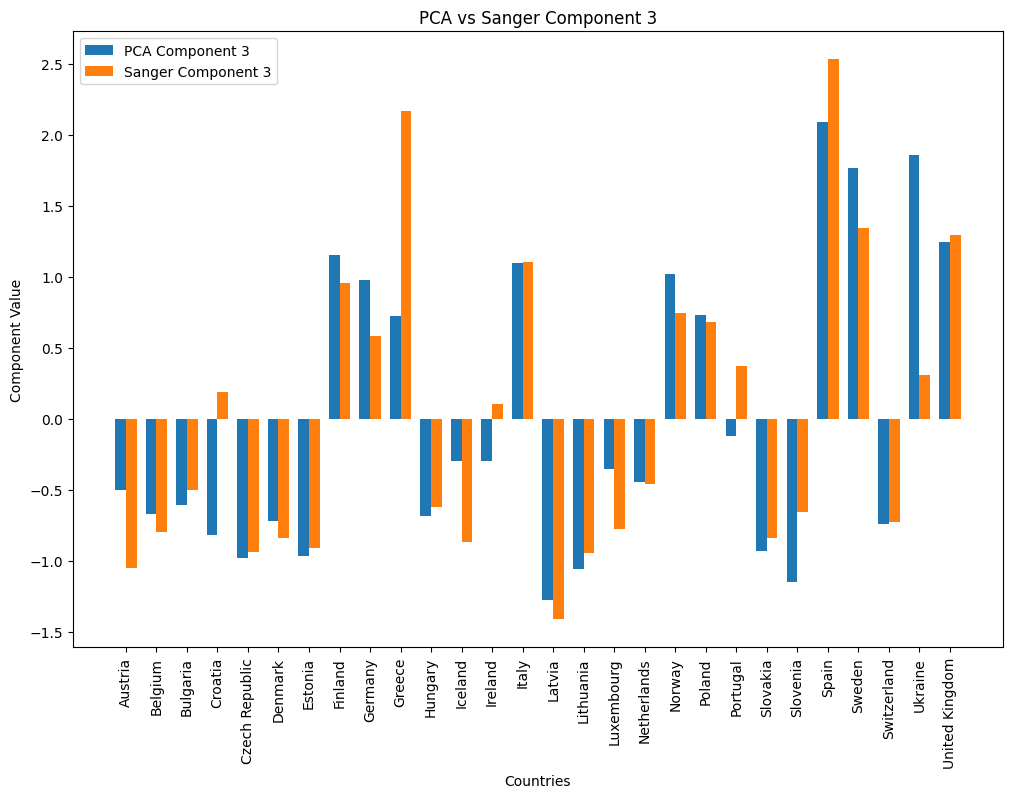

In [23]:
# Plot the results of PCA components vs Sanger components
def plot_component_comparison(sanger_weights, pca_components, num_components):
    for i in range(num_components):
        fig, ax = plt.subplots(figsize=(12, 8))

        pca_component = pca_components[:, i]
        sanger_component = np.dot(data.values, sanger_weights[i])

        # Adjust the sign of Sanger component to match PCA component
        if np.corrcoef(pca_component, sanger_component)[0, 1] < 0:
            sanger_component = -sanger_component

        index = np.arange(len(countries))
        bar_width = 0.35

        ax.bar(index, pca_component, bar_width, label=f"PCA Component {i+1}")
        ax.bar(index + bar_width, sanger_component, bar_width, label=f"Sanger Component {i+1}")

        ax.set_xlabel('Countries')
        ax.set_ylabel('Component Value')
        ax.set_title(f'PCA vs Sanger Component {i+1}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(countries, rotation=90)
        ax.legend()

        plt.show()

plot_component_comparison(sanger_weights, components_pca, num_components)


Converged after 211 epochs.
Sanger's rule completed 211 epochs.


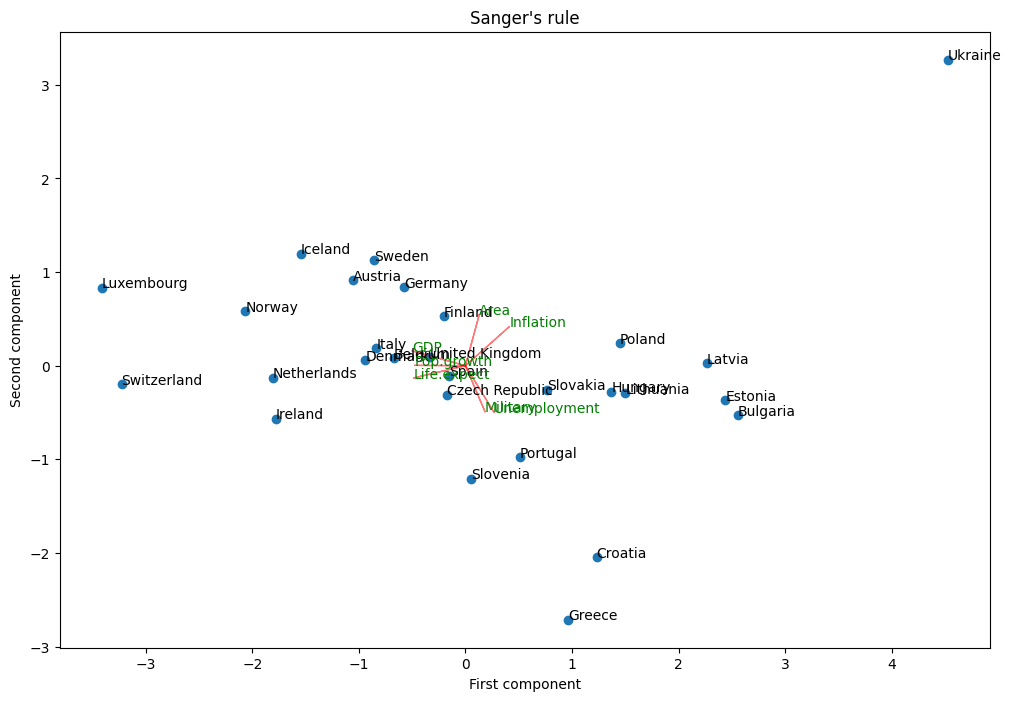

In [24]:
import matplotlib.pyplot as plt
from core.sanger import Sanger

# Now we use Sanger's rule to obtain the weights
sanger = Sanger(seed=42, num_features=data.shape[1], num_components=num_components, eta_function=divide_by_epoch)

# Fit the data
sanger_weights = sanger.fit(data.values, epochs=10000)

# Get the first two components of Sanger
sanger_lodaings_pc1 = sanger_weights[0]
sanger_lodaings_pc2 = sanger_weights[1]

# get the first two components of the data
sanger_component1 = np.dot(data.values, sanger_lodaings_pc1)
sanger_component2 = np.dot(data.values, sanger_lodaings_pc2)

plt.figure(figsize=(12, 8))

plt.scatter(sanger_component1, sanger_component2)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.title("Sanger's rule")

# Add country names to the dots
for i, country in enumerate(countries):
    plt.text(sanger_component1[i], sanger_component2[i], country)

# plot the loadings
features = full_data.columns[1:]
for i, feature in enumerate(full_data.columns[1:]):
    plt.arrow(0, 0, sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], color="red", alpha=0.5)
    plt.text(sanger_lodaings_pc1[i], sanger_lodaings_pc2[i], features[i], color="green")

plt.show()

